# A Tutorial of POD-DL-ROM for Nonlinear Parametrized PDEs

**Introduction:**

Proper Orthogonal Decomposition (POD) has long been a staple for the generation of Reduced Order Models (ROMs), especially in the domain of nonlinear, time-dependent parametrized partial differential equations (PDEs). However, conventional ROMs, despite their utility, suffer from various limitations. They often require projections onto high-dimensional linear approximating trial manifolds, resort to expensive hyper-reduction strategies, or grapple with the complexity of representing physical phenomena through a mere linear superimposition of modes.

Enter **Deep Learning-Based Reduced Order Models (DL-ROMs)**. By harnessing the power of neural networks—be they feedforward, convolutional, or autoencoder architectures—DL-ROMs offer a non-intrusive methodology. They efficiently learn both the nonlinear trial manifold and the reduced dynamics, sidestepping many of the challenges faced by their conventional counterparts.

However, like any deep learning model, DL-ROMs are not without their challenges. The extensive number of network parameters necessitates a potentially costly and time-consuming training process.

In this notebook, we walk through the approach taken in the paper below: **POD-DL-ROM**. By combining the dimensionality reduction capabilities of POD with a multi-fidelity pretraining stage, we propose a model that seamlessly integrates different physical models. The result is a highly efficient, generalized method tested across a range of time-dependent parametrized PDEs—including linear advection–diffusion–reaction, nonlinear diffusion–reaction, nonlinear elastodynamics, and Navier–Stokes equations.

> Fresca, Stefania, and Andrea Manzoni. "POD-DL-ROM: Enhancing deep learning-based reduced order models for nonlinear parametrized PDEs by proper orthogonal decomposition." Computer Methods in Applied Mechanics and Engineering 388 (2022): 114181. [Link](https://www.sciencedirect.com/science/article/pii/S0045782521005120)

**Objective:**

In this demonstration, we'll walk through the application of POD-DL-ROM on a Burger's Equation dataset. By varying the initial conditions, our aim will be to predict the output and showcase the efficiency and computational savings of our approach.


**Burger's Equation Dataset**

Recall the 1-d Burger's equation on the unit torus:
$$ \frac{\partial u(x, t)}{\partial t} + \frac{\partial (u^2(x, t)/2)}{\partial x} = \nu \frac{\partial^2 u(x, t)}{\partial x^2}, \quad x \in (0, 1), t \in (0, 1) $$
with the initial condition:
$$ u(x, 0) = u_0(x),  x \in (0, 1). $$

The initial condition $ u_0(x) $ is generated according to $ u_0 \sim \mu $ where $ \mu = N(0, 625 - \Delta + 25I)^{-2} $ with periodic boundary conditions. We set the viscosity to $ \nu = 0.1 $ and solve the equation using a split step method where the heat equation part is solved exactly in Fourier space then the non-linear part is advanced, again in Fourier space, using a very fine forward Euler method. We solve on a spatial mesh with resolution $ 2^{13} = 8192 $ and use this dataset to subsample other resolutions.

## DL-ROM

Consider a system with the following architecture:

### Spaces and Variables:
1. **Input Parameters Space:** Denoted by $ a $ and belonging to $ \mathbb{R}^m $, these parameters define the initial conditions or other features that dictate the behavior of our system.
   
2. **Output Solution Space:** Represented by $ u $ and existing in $ \mathbb{R}^n $, this captures the full-scale system's responses to the aforementioned input parameters.
   
3. **Reduced Subspace:** Defined by the POD (Proper Orthogonal Decomposition) Galerkin projection, this is a low-dimensional space represented by $ z $ in $ \mathbb{R}^p $, where $ p \ll n $. This subspace encapsulates the most significant modal characteristics of the system, thereby offering a compact representation.

### Neural Networks:

1. **Encoder (E):** Maps the full-scale system's response $ u $ to the reduced subspace: 
   $$ z = E(u) $$
   The encoder essentially captures the dominant features or modal characteristics of the system.

2. **Decoder (D):** Operates in the reverse direction, reconstructing the full-scale solution from the reduced subspace representation:
   $$ u = D(z) $$
   Its function is to approximate the inverse mapping of the encoder, essentially translating the reduced representations back to their full-scale counterparts.

3. **Latent Space Enforcer (F):** Directly maps the input parameters $ a $ to the reduced subspace:
   $$ z = F(a) $$
   It's intended to establish a direct relationship between the initial conditions or system parameters and the compact representation in the reduced subspace. In essence, it's a network representation of the system's behavior without resorting to the full-scale response.

### Reduced Order Model (ROM):

By training the encoder to map to the same subspace as the latent space enforcer, we ensure consistency in the reduced representations derived from both $ u $ and $ a $. This aligned mapping enables us to concatenate the latent space enforcer and the decoder to create a reduced order model. In this ROM, given any input parameter set $ a $, one can predict the full-scale system response $ u $ without ever computing in the full $ \mathbb{R}^n $ space, leveraging the reduced $ \mathbb{R}^p $ space for computational efficiency.

### Loss Function:

To ensure that the latent space enforcer network maps to the same subspace as the encoder network, we design a loss function $ L $ that balances between two objectives:

1. **Reconstruction Loss:** This term ensures that the decoded output from the reduced subspace (obtained via the encoder) closely matches the actual full-scale system response $ u $. Mathematically, this loss can be represented as:
   $$ \frac{1}{N} \sum_{i=1}^N \lambda \| D(E(u_i)) - u_i \|_2^2 $$
   Here, $ \lambda $ is a weighting factor that balances the two objectives, and $ N $ is the number of training samples.

2. **Latent Space Alignment Loss:** This term ensures that the decoder's output from the reduced subspace (again, obtained via the encoder) is consistent with the mapping provided by the latent space enforcer for the given input parameters $ a $. This term can be represented as:
   $$ \frac{1}{N} \sum_{i=1}^N (1-\lambda) \| D(E(u_i)) - F(a_i) \|_2^2 $$

The combined loss function, which balances between these two objectives, is given by:
$$ L = \frac{1}{N} \sum_{i=1}^N \lambda \| D(E(u_i)) - u_i \|_2^2 + (1-\lambda) \| D(E(u_i)) - F(a_i) \|_2^2 $$

By optimizing this loss function during the training process, we ensure that the reduced representations derived from both the encoder and the latent space enforcer are consistent and aligned. This effectively enforces that the latent space enforcer network maps to the same subspace as the encoder network, establishing a coherent relationship between the input parameters, reduced subspace, and the full-scale system response.

In [1]:
import torch
import gdown
import os
import scipy
import matplotlib.pyplot as plt
import numpy as np
import h5py
from functools import reduce
import operator

output = 'burgers_data_R10.mat'  # Change the extension to .zip (or whatever the actual extension is)

# Only download if the file doesn't exist
if not os.path.exists(output):
    url = 'https://drive.google.com/uc?export=download&id=1UsGPoCe8vXbLtD8tS2Azr88s8s-ZFJwr'
    gdown.download(url, output, quiet=False)
else:
    print(f"{output} already exists, skipping download.")

burgers_data_R10.mat already exists, skipping download.


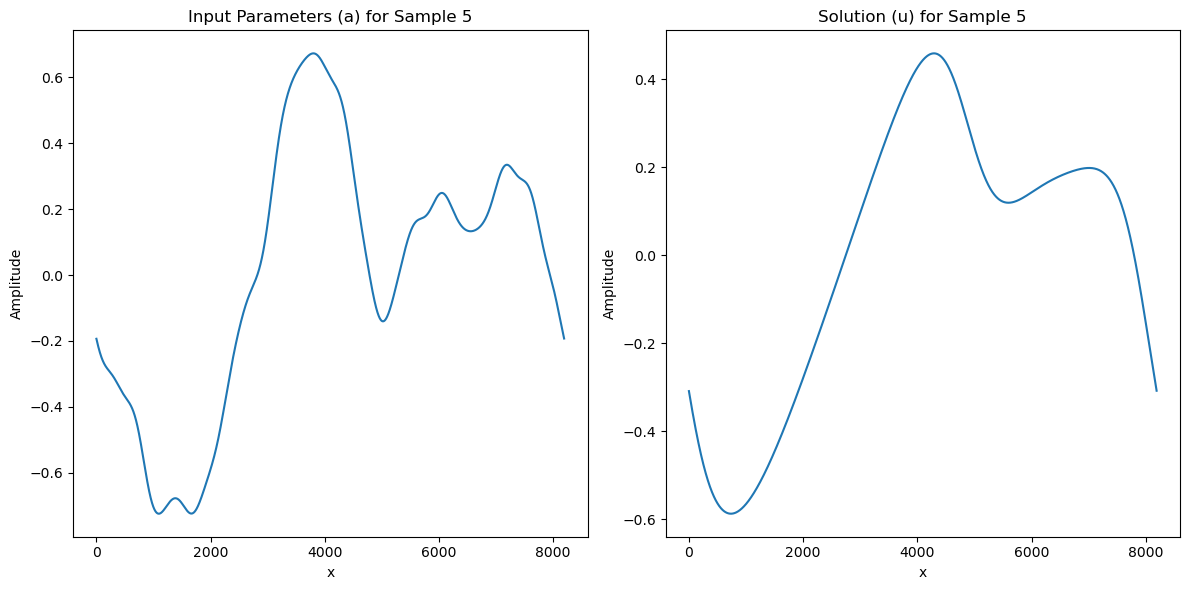

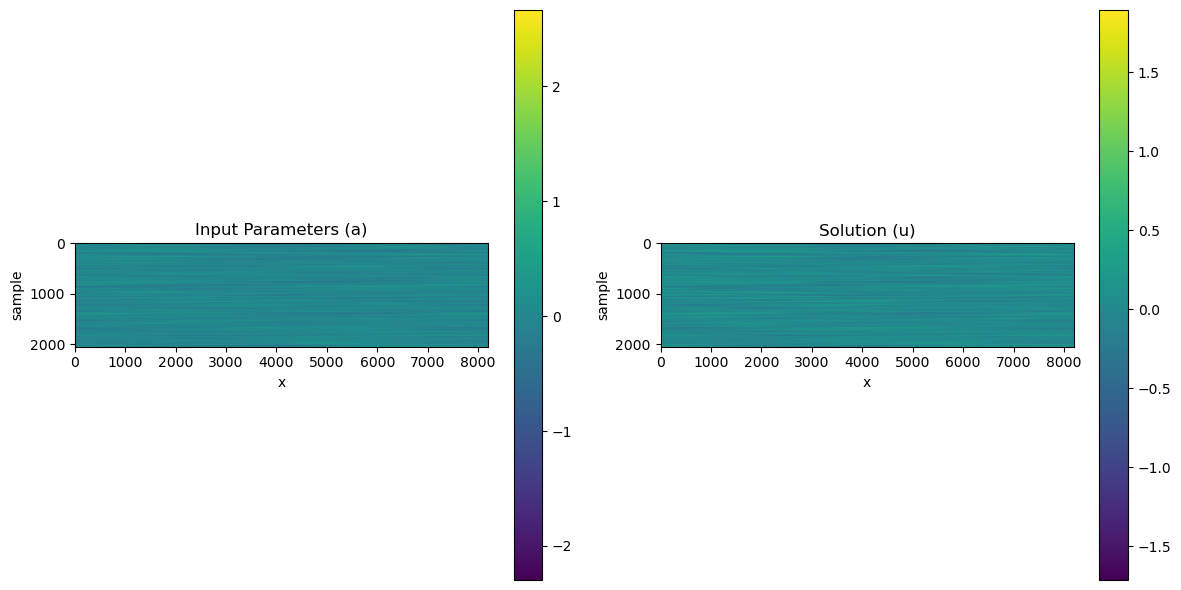

In [2]:
# Load the data
data = scipy.io.loadmat('burgers_data_R10.mat')


# Choose a specific sample index
sample_index = 5

# Extract the specific sample from data
input_sample = data['a'][sample_index]
solution_sample = data['u'][sample_index]

# Create a figure with two subplots side-by-side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Plot the input sample
ax1.plot(input_sample)
ax1.set_title(f'Input Parameters (a) for Sample {sample_index}')
ax1.set_xlabel('x')
ax1.set_ylabel('Amplitude')

# Plot the solution sample
ax2.plot(solution_sample)
ax2.set_title(f'Solution (u) for Sample {sample_index}')
ax2.set_xlabel('x')
ax2.set_ylabel('Amplitude')

# Adjust layout and display the plots
plt.tight_layout()
plt.show()


# Create a figure with two subplots side-by-side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Plot 'a' - the input parameters
cax1 = ax1.imshow(data['a'])
ax1.set_title('Input Parameters (a)')
ax1.set_xlabel('x')
ax1.set_ylabel('sample')
fig.colorbar(cax1, ax=ax1)

# Plot 'u' - the solution
cax2 = ax2.imshow(data['u'])
ax2.set_title('Solution (u)')
ax2.set_xlabel('x')
ax2.set_ylabel('sample')
fig.colorbar(cax2, ax=ax2)

# Adjust layout
plt.tight_layout()
plt.show()


In [3]:
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("Using CUDA.")

# elif torch.backends.mps.is_available():
#     device = torch.device("mps")
#     print("Using MPS.")

else:
    device = torch.device("cpu")
    print("Using CPU.")

Using CPU.


In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class Encoder(nn.Module):
    def __init__(self, input_dim, latent_dim, hidden_dim):
        super(Encoder, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, latent_dim)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

class Decoder(nn.Module):
    def __init__(self, latent_dim, output_dim, hidden_dim):
        super(Decoder, self).__init__()
        self.fc1 = nn.Linear(latent_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, output_dim)

    def forward(self, z):
        z = F.relu(self.fc1(z))
        z = self.fc2(z)
        return z

class LatentSpaceEnforcer(nn.Module):
    def __init__(self, param_dim, latent_dim, hidden_dim):
        super(LatentSpaceEnforcer, self).__init__()
        self.fc1 = nn.Linear(param_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, latent_dim)

    def forward(self, a):
        a = F.relu(self.fc1(a))
        a = self.fc2(a)
        return a

# Define the combined model
class CombinedModel(nn.Module):
    def __init__(self, input_dim, output_dim, latent_dim, param_dim, hidden_dim):
        super(CombinedModel, self).__init__()
        self.encoder = Encoder(input_dim, latent_dim, hidden_dim)
        self.decoder = Decoder(latent_dim, output_dim, hidden_dim)
        self.latent_space_enforcer = LatentSpaceEnforcer(param_dim, latent_dim, hidden_dim)

    def forward(self, x):
        z = self.encoder(x)
        u_pred = self.decoder(z)
        z_enforced = self.latent_space_enforcer(x)
        return u_pred, z, z_enforced

In [5]:
class MatReader:
    def __init__(self, file_path, to_torch=True, to_cuda=False, to_float=True):
        """
        Initialize a MatReader object.
        
        :param file_path: Path to the .mat file.
        :param to_torch: Convert numpy arrays to PyTorch tensors.
        :param to_cuda: Move tensors to GPU.
        :param to_float: Convert data to float type.
        """
        self.to_torch = to_torch
        self.to_cuda = to_cuda
        self.to_float = to_float

        self.data = self._load_file(file_path)

    def _load_file(self, file_path):
        """
        Load the .mat file.
        
        :param file_path: Path to the .mat file.
        """
        try:
            data = scipy.io.loadmat(file_path)
            old_mat = True
        except NotImplementedError:
            data = h5py.File(file_path, 'r')
            old_mat = False

        return {'data': data, 'old_mat': old_mat}

    def read_field(self, field):
        """
        Read the specified field from the .mat file.
        
        :param field: Name of the field to read.
        """
        x = self.data['data'][field]

        if not self.data['old_mat']:
            x = x[()]
            x = np.transpose(x, axes=range(len(x.shape) - 1, -1, -1))

        if self.to_float:
            x = x.astype(np.float32)

        if self.to_torch:
            x = torch.from_numpy(x)
            if self.to_cuda:
                x = x.cuda()

        return x

    def set_cuda(self, to_cuda):
        """Set the to_cuda flag."""
        self.to_cuda = to_cuda

    def set_torch(self, to_torch):
        """Set the to_torch flag."""
        self.to_torch = to_torch

    def set_float(self, to_float):
        """Set the to_float flag."""
        self.to_float = to_float


In [7]:
def load_data(file_name, ntrain, ntest, sub):
    dataloader = MatReader(file_name)
    x_data = dataloader.read_field('a')[:, ::sub]
    y_data = dataloader.read_field('u')[:, ::sub]

    x_train = x_data[:ntrain, :]
    y_train = y_data[:ntrain, :]
    x_test = x_data[-ntest:, :]
    y_test = y_data[-ntest:, :]
    return x_train, y_train, x_test, y_test

################################################################
# configurations
################################################################

CONFIG = {
    'train_data_res': 128,
    'save_index': 0,
    'ntrain': 1000,
    'ntest': 200,
    'sub': 2**13 // 128,
    'batch_size': 50,
    'param_dim': 128,
    'latent_dim': 64,
    'hidden_dim': 256,
    'output_dim': 128,
    'input_dim': 128,
    'learning_rate': 0.001,
    'epochs': 1000,
    'step_size': 100,
    'gamma': 0.5,
    'modes': 8,
    'width': 128,
    'file_name': 'burgers_data_R10.mat',
}

x_train, y_train, x_test, y_test = load_data(CONFIG['file_name'], CONFIG['ntrain'], CONFIG['ntest'], 
                                             CONFIG['sub'])
train_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(x_train, y_train), 
                                           batch_size=CONFIG['batch_size'], shuffle=True)
test_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(x_test, y_test), 
                                          batch_size=CONFIG['batch_size'], shuffle=False)



################################################################
# Training and Evaluation
################################################################
model = CombinedModel(CONFIG['input_dim'], CONFIG['output_dim'], CONFIG['latent_dim'], CONFIG['param_dim'], CONFIG['hidden_dim'])
optimizer = torch.optim.Adam(model.parameters(), lr=CONFIG['learning_rate'], weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=CONFIG['step_size'], gamma=CONFIG['gamma'])

# Loss function
def loss_function(u_pred, u_true, z, z_enforced, lambda_coeff=0.5):
    recon_loss = nn.MSELoss()(u_pred, u_true)
    enforcement_loss = nn.MSELoss()(z, z_enforced)
    return lambda_coeff * recon_loss + (1 - lambda_coeff) * enforcement_loss


# Training and evaluation loop
for epoch in range(CONFIG['epochs']):
    model.train()
    train_loss = 0
    
    # Training
    for batch_idx, (x_batch, y_batch) in enumerate(train_loader):
        optimizer.zero_grad()

        u_pred, z, z_enforced = model(x_batch)

        loss = loss_function(u_pred, y_batch, z, z_enforced)
        loss.backward()
        
        optimizer.step()
        train_loss += loss.item()

    scheduler.step()
    
    # Evaluation
    model.eval()  # set the model to evaluation mode
    test_loss = 0
    with torch.no_grad():  # disable gradient computation during evaluation
        for x_batch, y_batch in test_loader:
            u_pred, z, z_enforced = model(x_batch)
            loss = loss_function(u_pred, y_batch, z, z_enforced)
            test_loss += loss.item()

    print(f"Epoch {epoch+1}/{CONFIG['epochs']}, Train Loss: {train_loss / len(train_loader)}, Test Loss: {test_loss / len(test_loader)}")


Epoch 1/1000, Train Loss: 0.08226698935031891, Test Loss: 0.03288871329277754
Epoch 2/1000, Train Loss: 0.022634215466678143, Test Loss: 0.015425088349729776
Epoch 3/1000, Train Loss: 0.013716277154162525, Test Loss: 0.01230831234715879
Epoch 4/1000, Train Loss: 0.010940460348501801, Test Loss: 0.009809120325371623
Epoch 5/1000, Train Loss: 0.008666820568032562, Test Loss: 0.008071434684097767
Epoch 6/1000, Train Loss: 0.007008934277109802, Test Loss: 0.0065789102809503675
Epoch 7/1000, Train Loss: 0.005949993175454438, Test Loss: 0.005564657156355679
Epoch 8/1000, Train Loss: 0.005218817270360887, Test Loss: 0.005399986286647618
Epoch 9/1000, Train Loss: 0.004941668431274593, Test Loss: 0.005170051765162498
Epoch 10/1000, Train Loss: 0.004605894593987614, Test Loss: 0.004794257110916078
Epoch 11/1000, Train Loss: 0.00450500474544242, Test Loss: 0.004599034087732434
Epoch 12/1000, Train Loss: 0.0043690711609087884, Test Loss: 0.004554996965453029
Epoch 13/1000, Train Loss: 0.0041412174

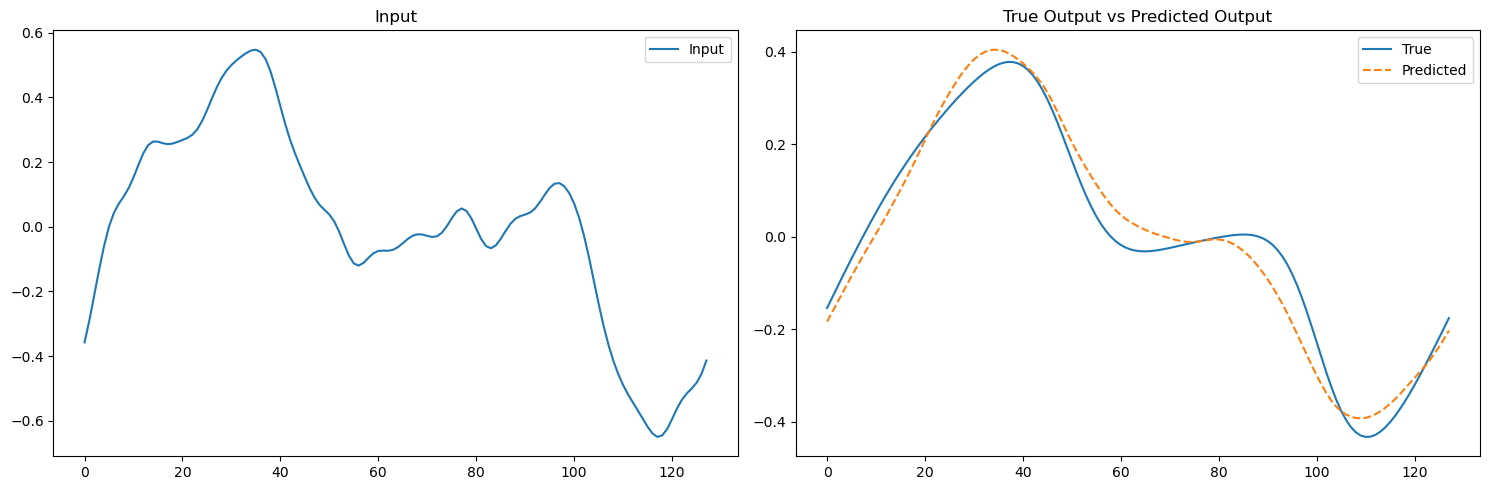

In [17]:
def plot_results(input_data, true_output, predicted_output, sample_idx):
    """Plot the input data, true output and the predicted output for a given sample index."""
    fig, ax = plt.subplots(1, 2, figsize=(15, 5))

    # Input data plot
    ax[0].plot(input_data[sample_idx].cpu().numpy(), label='Input')
    ax[0].set_title('Input')
    ax[0].legend()

    # True vs. Predicted output plot
    ax[1].plot(true_output[sample_idx].cpu().numpy(), label='True')
    ax[1].plot(predicted_output[sample_idx].cpu().numpy(), linestyle='dashed', label='Predicted')
    ax[1].set_title('True Output vs Predicted Output')
    ax[1].legend()

    plt.tight_layout()
    plt.show()

# Fetch the first batch of test data
x_test_batch, y_test_batch = next(iter(test_loader))

# Set the model to evaluation mode
model.eval()

# Predict using the model without computing gradients
with torch.no_grad():
    latent_outputs = model.latent_space_enforcer(x_test_batch)
    predicted_outputs = model.decoder(latent_outputs)

# Index of the sample you want to visualize
sample_index = 30

# Call the plotting function
plot_results(x_test_batch, y_test_batch, predicted_outputs, sample_index)


From the paper...


### Problem Statement

We consider a generic nonlinear, time-dependent PDE that is influenced by a set of input parameters $ \mu \in P $. Here, the parameter space $ P \subset \mathbb{R}^{n_{\mu}} $ is a bounded and closed set. Such input parameters can encapsulate physical or geometrical attributes of the system, like material properties, initial/boundary conditions, or domain shape. In this context, even if our primary focus is on physical parameters, accommodating geometrical parameters doesn't demand additional efforts. 

Assuming a fully algebraic viewpoint, our starting point is the high-fidelity (spatial) approximation of the PDE, referred to as the full order model (FOM). Regardless of the specific spatial discretization in play—may it be the finite element method, Isogeometric Analysis, or the spectral element method—the FOM can be distilled down to a nonlinear parametrized dynamical system. Thus, for any given $ \mu \in P $, our objective is to tackle the initial value problem:

\begin{align}
M(\mu)u_h^{\prime}(t;\mu) &= f(t, u_h(t;\mu);\mu) \quad t \in (0, T), \tag{1} \\
u_h(0;\mu) &= u_0(\mu). \tag{2}
\end{align}

where:

- $ u_h : [0, T) \times P \to \mathbb{R}^{N_h} $ represents the parametrized solution of the mentioned system.
- $ u_0 : P \to \mathbb{R}^{N_h} $ is the initial data.
- $ f : (0, T) \times \mathbb{R}^{N_h} \times P \to \mathbb{R}^{N_h} $ is the (nonlinear) function depicting the system dynamics.
- $ M(\mu) \in \mathbb{R}^{N_h \times N_h} $ is the parametric mass matrix associated with this parametric FOM. For the scope of this discussion, $ M(\mu) $ is taken to be a symmetric positive definite matrix.

### FOM Approximation
The FOM dimension $N_h$ is related to the finite-dimensional subspaces introduced for the sake of space discretization. Here, $h > 0$ denotes a discretization parameter, such as the maximum diameter of elements in a computational mesh. Consequently, $N_h$ can be extremely large if the PDE problem describes complex physical behaviors and/or high degrees of accuracy are required for its solution. In order to solve this problem (1), suitable time discretizations are employed, such as backward differentiation formulas (BDFs) and generalized-$\alpha$ methods. We thus aim at approximating, in an efficient way, the set
$$
S_h = \{u_h(t;\mu) \mid t \in [0, T), \mu \in P \subset \mathbb{R}^{n_{\mu}}\} \subset \mathbb{R}^{N_h}.
$$

$S^{\sim}_{n,\text{lin}}$ is defined as
$$
S^{\sim}_{n,\text{lin}} = \{V_n u_n(t;\mu) \mid u_n(t;\mu) \in \mathbb{R}^n, t \in [0, T), \mu \in P \subset \mathbb{R}^{n_{\mu}}\} \subset \mathbb{R}^{N_h}. \tag{4}
$$

In POD-Galerkin ROMs, $S^{\sim}_{n,\text{lin}}$ is spanned by the first $n$ singular vectors of the matrix $S$ defined as
$$
S = [u_1h(t_1;\mu_1) \mid \ldots \mid u_1h(t_{N_t};\mu_1) \mid \ldots \mid \ldots u_1h(t_1;\mu_{N_{\text{train}}}) \mid \ldots \mid u_1h(t_{N_t};\mu_{N_{\text{train}}})]. \tag{5}
$$

This matrix collects FOM solutions (or snapshots) computed for different parameter values $\mu_1, \ldots, \mu_{N_{\text{train}}}$ in $P$, suitably sampled over the parameter space, at different time instants $t_1, \ldots, t_{N_t} \subset [0, T]$.


### POD-Galerkin
In the POD-Galerkin case, to model the reduced dynamics of the system, we replace $u_h(t;\mu)$ by (3) in system (1) and impose that the residual
$$
r_h(V_n u_n(t;\mu)) = M(\mu)V_n u_n^{\prime}(t;\mu) - f(t, V_n u_n(t;\mu);\mu) \tag{6}
$$
is orthogonal to $S^{\sim}_{n,\text{lin}}$. This condition yields the following POD-Galerkin ROM:
\begin{align}
M_n(\mu)u_n^{\prime}(t;\mu) &= f_n(t, V_n u_n(t;\mu);\mu) \quad t \in (0, T), \tag{7} \\
u_n(0;\mu) &= V_n^T u_0(\mu). \tag{8}
\end{align}
where:
- $M_n(\mu) = V_n^T M(\mu)V_n$ is the reduced mass matrix,
- $f_n(t, V_n u_n(t;\mu);\mu) = V_n^T f(t, V_n u_n(t;\mu);\mu)$,
- $u_n(0;\mu) = V_n^T u_h(0;\mu)$ is the initial condition for $u_n(t;\mu)$ associated with the initial condition for $u_h(t;\mu)$. Here, we have assumed, without loss of generality, that $V_n^T V_n = I \in \mathbb{R}^{n \times n}$.


The two main bottlenecks often arising with POD-Galerkin ROMs are (i) the increasing dimension $n \gg n_{\mu} + 1$ of the low-dimensional POD subspaces, much larger than the intrinsic dimension of the solution manifold, and (ii) the need to rely on hyper-reduction techniques to assemble the operators appearing in the ROM (7) in order not to rely on expensive $N_h$-dimensional arrays.

### DL-ROMs
DL-ROMs have been introduced in to overcome these limitations of POD-Galerkin ROMs. A DL-ROM describes both the trial manifold and the reduced dynamics (corresponding to the matrix $V_n$ and the projection stage, respectively, in the POD-Galerkin case) through deep neural networks, which are trained on a set of FOM snapshots. In this way, DL-ROMs completely avoid the projection stage, are non-intrusive, and can be cheaply evaluated once trained. In particular:
\begin{itemize}
  \item To describe the system dynamics on a suitable reduced nonlinear trial manifold (a task which we refer to as reduced dynamics learning), the intrinsic coordinates of the ROM approximation are defined as
  $$
  u_n(t;\mu, \theta_{DF}) = \phi_{DF}^n(t;\mu, \theta_{DF}), \tag{8}
  $$
  where $\phi_{DF}^n(\cdot;\cdot, \theta_{DF}) : \mathbb{R}^{(n_{\mu}+1)} \to \mathbb{R}^n$ is a deep feedforward neural network (DFNN), consisting of the subsequent composition of a nonlinear activation function, applied to a linear transformation of the input, multiple times. Here, $\theta_{DF}$ denotes the
\end{itemize}

The vector of parameters of the DFNN, collecting all the corresponding weights and biases of each layer of the DFNN;

To model the reduced nonlinear trial manifold $S^{\sim}_n h \approx Sh$ (a task which we refer to as reduced trial manifold learning), we employ the decoder function of a CAE, that is,
$$
S^{\sim}_n h = \{f_D^h(u_n(t;\mu,\theta_{DF});\theta_D) \mid u_n(t;\mu,\theta_{DF}) \in \mathbb{R}^n, t \in [0, T) \text{ and } \mu \in P \subset \mathbb{R}^{n_{\mu}}\} \subset \mathbb{R}^{N_h}, \tag{9}
$$
where $f_D(\cdot;\theta_D) : \mathbb{R}^n \to \mathbb{R}^{N_h}$ denotes the decoder function of a CAE obtained as the composition of several layers (some of which are convolutional), depending upon a vector $\theta_D$ collecting all the corresponding weights and biases.

The DL-ROM approximation $u^{\sim}_h(t;\mu) \approx u_h(t;\mu)$ is then given by
$$
u^{\sim}_h(t;\mu,\theta_{DF},\theta_D) = f_D^h(\phi_{DF}^n(t;\mu,\theta_{DF});\theta_D). \tag{10}
$$

The encoder function $f_E^n(\cdot;\theta_E)$ of the CAE, provided when carrying out its training on the FOM snapshots, can then be exploited to map the FOM solution associated with $(t,\mu)$ onto a low-dimensional representation
$$
u^{\sim}_n(t;\mu,\theta_E) = f_E^n(u_h(t;\mu);\theta_E); \tag{11}
$$
where $f_E^n(\cdot;\theta_E) : \mathbb{R}^{N_h} \to \mathbb{R}^n$ denotes the encoder function, depending upon a vector $\theta_E$ of parameters.

Computing the DL-ROM approximation of $u_h(t;\mu_{\text{test}})$, for any possible $t \in (0, T)$ and $\mu_{\text{test}} \in P$, corresponds to the testing stage of a DFNN and of the decoder function of a CAE; this does not require the evaluation of the encoder function. The training stage consists in solving the following optimization problem, in the variable $\theta = (\theta_E, \theta_{DF}, \theta_D)$, after the snapshot matrix $S$ has been formed:
\begin{align*}
\min_{\theta} J(\theta) &= \min_{\theta} \frac{1}{N_s}\sum_{i=1}^{N_{\text{train}}}\sum_{k=1}^{N_t} L(t_k,\mu_i;\theta), \tag{12}
\end{align*}
where $N_s = N_{\text{train}} \cdot N_t$ and
\begin{align*}
L(t_k,\mu_i;\theta) &= \omega_h^2 L_{\text{rec}}(t_k,\mu_i;\theta) + (1 - \omega_h^2) L_{\text{int}}(t_k,\mu_i;\theta), \tag{13}
\end{align*}
where
\begin{align*}
L_{\text{rec}}(t_k,\mu_i;\theta) &= \left\| u(t_k;\mu_i) - u^{\sim}(t_k;\mu_i,\theta_{DF},\theta_D) \right\|_2, \tag{14}
\end{align*}
and
\begin{align*}
L_{\text{int}}(t_k,\mu_i;\theta) &= \left\| u^{\sim}_n(t_k;\mu_i,\theta_E) - u_n(t_k;\mu_i,\theta_{DF}) \right\|_2, \tag{14}
\end{align*}
with $\omega_h \in [0,1]$. The per-example loss function (13) combines the reconstruction error (that is, the error between the FOM solution and the DL-ROM approximation) and the error between the intrinsic coordinates and the output of the encoder.

### Remarks
We remark that our choice to provide the output of the DFNN, i.e., $u_n(t;\mu,\theta_{DF})$, as input to the decoder function $f_D^h(u_n(t;\mu,\theta_{DF});\theta_D)$ of the CAE, rather than replacing the DFNN with the encoder function $f_E^n(u_h(t;\mu);\theta_E)$, is related to the fact that, at testing time, we do not want to feed the FOM solution as input to the DL-ROM. In this way, at testing time, the evaluation of the trained network is completely independent from high-fidelity (and high-dimensional) full-order data. Moreover, motivated by the need to discard the encoder function at testing time, we maintain the same structure of the DL-ROM network also at training time, in order to enhance the decoder function's robustness, making it stable with respect to possible perturbations affecting the intrinsic coordinates—these latter being the actual input provided to $f_D^h(u_n(t;\mu,\theta_{DF});\theta_D)$ at testing time. We also point out that, by exploiting this structure, the updates of the parameters of the DFNN $\theta_{DF}$ depend not only on the gradients of the error between the intrinsic coordinates and the encoder output but also on the gradients of the reconstruction error.



![Image Alt Text](https://drive.google.com/uc?export=view&id=1yX2KU1X3B-IYFUz-pBDITTFGQqk-Vx02)
